## Use pretained model from vggFace

In [145]:
from keras_vggface.vggface import VGGFace

# Based on VGG16 architecture -> old paper(2015)
# Method: Deep Face Recognition (trained on 982k images, however, the actual training hours were not reported)
vggface = VGGFace(model='vgg16') 

In [146]:
from keras.engine import  Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace

# Convolution Features
vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max

In [147]:
print(vggface.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [148]:
print(vgg_features.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [149]:
# load training and test data
import pickle
import numpy as np
from sklearn.preprocessing import label_binarize

with open("data/image_data_train224.pkl","rb") as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    data_train = u.load()

with open("data/image_data_test224.pkl","rb") as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    data_test = u.load()

with open("data/class_list.pkl", "rb") as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    class_list = u.load()



X_train = np.array([x[0]/255. for x in data_train])
X_test = np.array([x[0]/255. for x in data_test])

Y_train = np.array([x[1] for x in data_train])
Y_test = np.array([x[1] for x in data_test])

Y_train_one_hot = label_binarize(np.array([x[1] for x in data_train]),class_list)
Y_test_one_hot = label_binarize(np.array([x[1] for x in data_test]), class_list)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(93, 224, 224, 3)
(93,)
(25, 224, 224, 3)
(25,)


In [150]:
X_train_embedding = vgg_features.predict(X_train)
X_test_embedding = vgg_features.predict(X_test)

In [151]:
from sklearn.linear_model import LogisticRegression as LR

print('Train set shape: ', X_train_embedding.shape)
print('Test set shape: ', X_test_embedding.shape)

print (Y_test)

# short cut to only train the last layer
model = LR()
model.fit(X_train_embedding, Y_train)
print ("training accuracy: ", model.score(X_train_embedding, Y_train))
print ("test accuracy: ", model.score(X_test_embedding, Y_test))

Train set shape:  (93, 512)
Test set shape:  (25, 512)
[b'ben_afflek' b'ben_afflek' b'ben_afflek' b'ben_afflek' b'ben_afflek'
 b'elton_john' b'elton_john' b'elton_john' b'elton_john' b'elton_john'
 b'jerry_seinfeld' b'jerry_seinfeld' b'jerry_seinfeld' b'jerry_seinfeld'
 b'jerry_seinfeld' b'madonna' b'madonna' b'madonna' b'madonna' b'madonna'
 b'mindy_kaling' b'mindy_kaling' b'mindy_kaling' b'mindy_kaling'
 b'mindy_kaling']
training accuracy:  0.989247311827957
test accuracy:  1.0


## Face Detection

In [152]:
import cv2 as cv
import os
import matplotlib.pyplot as plt

%matplotlib inline
# preprocessing data, locate the faces
# given the picture, retate it from -60 to 60, find the face with the best matching score
# crop the one, return the cropped face

# copy from previous example
# not required to understand, just use it as utility
def rotate_image_without_crop(image, angle):
    
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2., h / 2.)
 
    M = cv.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    return cv.warpAffine(image, M, (nW, nH))

def crop_image(img, faceR):
    (x, y, w, h) = faceR
    return img[y:y+h, x:x+w].copy()

def detect_face(image):
    result = None
    imageGray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    cascade = cv.CascadeClassifier("/Users/LiangTan/anaconda3/pkgs/opencv-3.3.1-py36h60a5f38_1/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml")
    
    angle_range = np.arange(-60, 60, 5)
    
    best_face = None
    best_angle = None
    max_weight = 0
    for angle in angle_range:
        imageGray_rotated = rotate_image_without_crop(imageGray, angle)
        # there may be multiple faces in a pic
        faceRects, rejectLevels, levelWeights = cascade.detectMultiScale3(imageGray_rotated, scaleFactor=1.05, minNeighbors=3, minSize=(5,5), outputRejectLevels=True)
    
        if len(faceRects) <= 0:
            continue
        else:
            # for all the faces detected in a pic, find the largest shape one. It is our assumption
            # when doing prediciton, it is of course not a problem to do multiple face detection
            # but in training, it is hard to believe there are two faces of the same person.
            face, weight = max([(faceR, weight) for faceR, weight in zip(faceRects, levelWeights)], key = lambda x: x[0][2]*x[0][3]) 
#             print weight, angle
            if (weight > max_weight):
                max_weight = weight
                best_face = face
                best_angle = angle
    
    if(best_face is None):
        return None
    else:
        rotated_img = rotate_image_without_crop(image, best_angle)
        return crop_image(rotated_img, best_face)

## Pilot Test
### Who looks like you

(900, 900, 3)


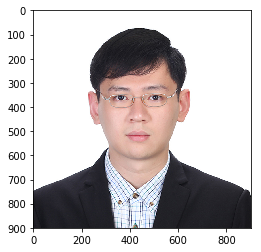

In [153]:
# 1. load an image of mine

test_image = cv.imread('images/Liang.jpg')

print(test_image.shape)

plt.imshow(test_image[:,:,::-1])
plt.show()

In [154]:
detected_face = detect_face(test_image)

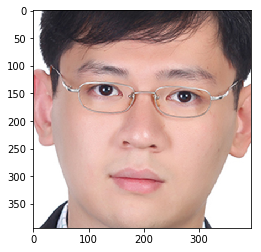

In [155]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(detected_face[:,:,::-1])
plt.show()

In [156]:
detected_face_resized = cv.resize(detected_face/255., (224, 224)) # now the dimsion is 224*224*3

In [157]:
detected_face_embedding = vgg_features.predict(np.expand_dims(detected_face_resized, axis=0)) 
# now the dimension is (1,224,224,3)
# because the input must be (N,224, 224,3)

print(zip(class_list,model.predict_proba(detected_face_embedding)[0]))
print(model.predict(detected_face_embedding))

[b'mindy_kaling']


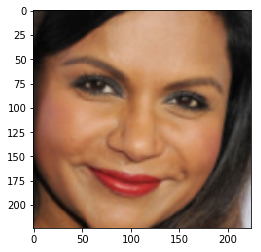

In [158]:
mask = [item == b'mindy_kaling' for item in Y_train]
mindy_kaling = X_train[mask]
plt.imshow(mindy_kaling[6][:,:,::-1])
plt.show()

### find out which picture is mostly similar

In [110]:
from scipy.spatial.distance import cdist

mindy_kaling_embedding = vgg_features.predict(mindy_kaling)

distances = cdist(detected_face_embedding, mindy_kaling_embedding).flatten()

indices = distances.flatten().argsort()

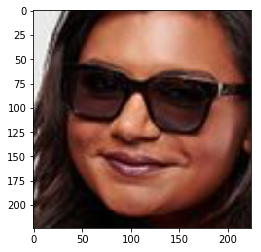

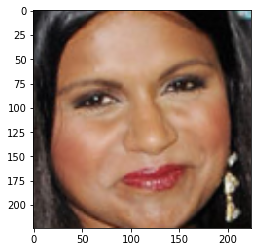

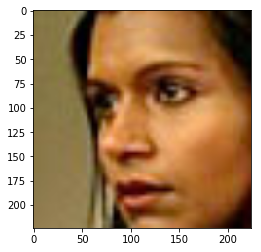

In [111]:
for i in indices[:3]:
    plt.imshow(mindy_kaling[i][:,:,::-1])
    plt.show()

### now let's combine everything

In [127]:
class FaceRecognition():
    def __init__(self, embedding_model, classifier_model, size = (224, 224), X_train = None, Y_train = None):
        self.embedding_model = embedding_model
        self.classifier_model = classifier_model
        self.size = size
        self.X = X_train
        self.Y = Y_train
        if (self.X is not None):
            print("Computing the embedding for training data.")
        self.embedding = self.embedding_model.predict(self.X) if self.X is not None else None
    
    def compute_embedding(self, filename):
        test_image = cv.imread(filename)
        print("loading image.")
        plt.imshow(test_image[:,:,::-1])
        plt.show()
        print("image loaded\n")
        detected_face = detect_face(test_image)
        if(detected_face is None):
            print("Oops, no face has been detected")
            return None
        else:
            print("Face has been detected\n")
            plt.imshow(detected_face[:,:,::-1])
            plt.show()
            test_face_resized = cv.resize(detected_face, self.size)/255.
            test_face_embedding = self.embedding_model.predict(np.expand_dims(test_face_resized, axis=0))
        return test_face_embedding
        
        
    def predict_image_single_face(self, filename, return_embedding = False):
        test_face_embedding = self.compute_embedding(filename)
        predictions = zip(class_list,self.classifier_model.predict_proba(test_face_embedding)[0])
        max_pair = max(predictions, key = lambda pair: pair[1])
        print("Prediction results:")
        for pair in predictions:
            print("Identity: %s, Prob %f" %(pair[0], pair[1]))
  
        print("\nThis face has been recognized as: %s with prob %f" %(max_pair[0], max_pair[1]))
        if(self.X is not None):
            print("Now search for the most similar Faces")
            mask = self.Y == max_pair[0]
            distances = cdist(test_face_embedding, self.embedding[mask]).flatten()
            indices = distances.flatten().argsort()[:3]
            print("displaying the top 3 ...")
            for i in indices:
                plt.imshow(self.X[mask][i][:,:,::-1])
                plt.show()
        if(return_embedding):
            return test_face_embedding
        else:
            return None
                

In [128]:
myFaceRecog = FaceRecognition(vgg_features, model, X_train = X_train, Y_train = Y_train)

Computing the embedding for training data.


loading image.


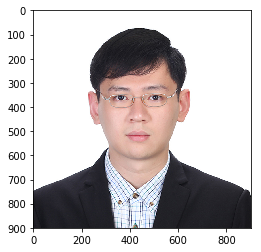

image loaded

Face has been detected



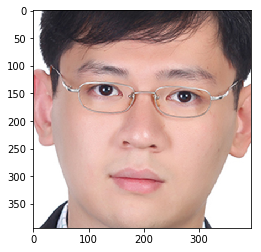

Prediction results:

This face has been recognized as: b'mindy_kaling' with prob 0.238833
Now search for the most similar Faces
displaying the top 3 ...


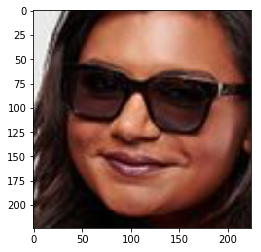

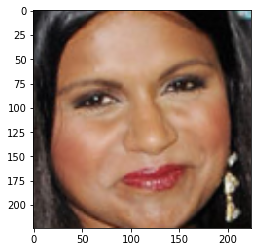

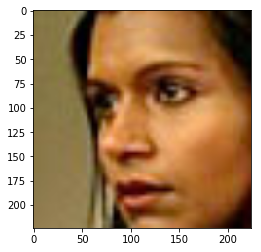

In [129]:
myFaceRecog.predict_image_single_face('images/Liang.jpg')

loading image.


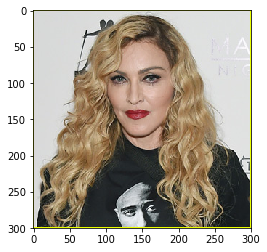

image loaded

Face has been detected



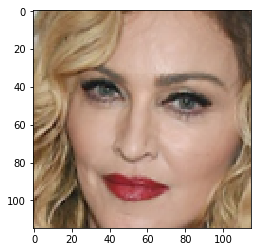

Prediction results:

This face has been recognized as: b'madonna' with prob 0.461078
Now search for the most similar Faces
displaying the top 3 ...


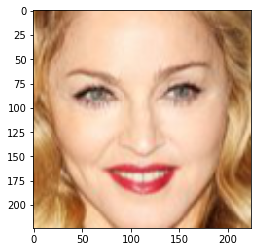

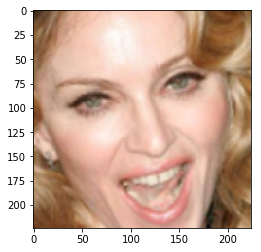

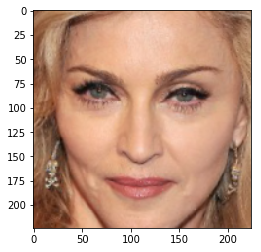

In [130]:
myFaceRecog.predict_image_single_face('images/madonna2.jpg')

In [131]:
myFaceRecog2 = FaceRecognition(vgg_features, model)

loading image.


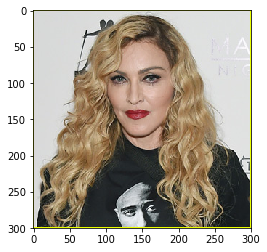

image loaded

Face has been detected



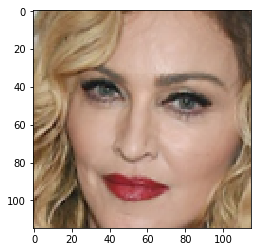

In [132]:
x = myFaceRecog2.compute_embedding('images/madonna2.jpg')

loading image.


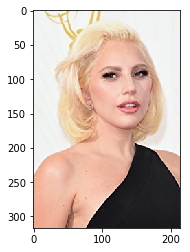

image loaded

Face has been detected



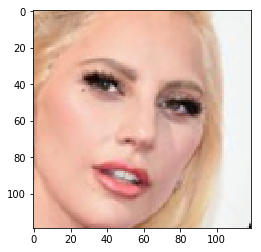

Prediction results:

This face has been recognized as: b'madonna' with prob 0.286047
Now search for the most similar Faces
displaying the top 3 ...


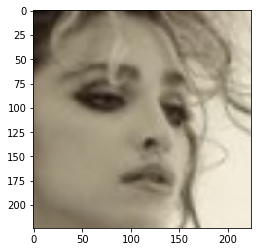

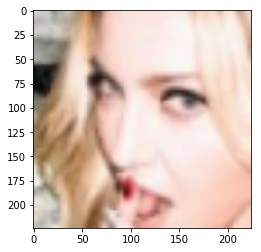

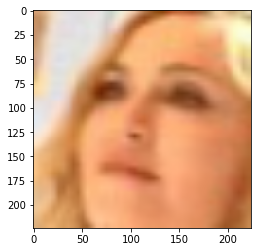

In [133]:
myFaceRecog.predict_image_single_face('images/ladygaga.jpg')

In [135]:
from keras_vggface import utils
preds = vggface.predict(X_train[:3])
print(utils.decode_predictions(preds))

352256/346184 [==============================] - 0s 1us/step
[[["b'Russell_Tovey'", 0.00040228982], ["b'Drew_Seeley'", 0.0004016377], ["b'Tim_Pocock'", 0.00040005782], ["b'Louis_Tomlinson'", 0.00039840606], ["b'Ashton_Holmes'", 0.00039817422]], [["b'Ty_Olsson'", 0.00040251858], ["b'Jeremy_Davies'", 0.00040092348], ["b'Joss_Whedon'", 0.00039982836], ["b'John_Ritter'", 0.0003998255], ["b'Matt_Berry'", 0.00039963878]], [["b'Zack_Snyder'", 0.0004014829], ["b'Max_Ryan'", 0.00040049877], ["b'Ben_Miller'", 0.00039991358], ["b'Brett_Davern'", 0.00039908572], ["b'Jai_Courtney'", 0.00039887452]]]


## detect multiple faces

In [167]:
def detect_multiple_face_simple(image):
#     cascadePath = os.path.join(cv.data.haarcascades, "haarcascade_frontalface_default.xml")

    #cascadePath = os.path.join(cv.data.haarcascades, "haarcascade_frontalface_alt.xml")
    result = None
    imageGray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    cascade = cv.CascadeClassifier("/Users/LiangTan/anaconda3/pkgs/opencv-3.3.1-py36h60a5f38_1/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml")
    
    # there may be multiple faces in a pic
    faceRects, rejectLevels, levelWeights = cascade.detectMultiScale3(imageGray, scaleFactor=1.05, minNeighbors=3, minSize=(15,15), outputRejectLevels=True)

    result = []
    if len(faceRects) <= 0:
        return []
    
    for rect in faceRects:
        result.append(crop_image(image, rect))
        
    return result

In [168]:
class FaceRecognition_multiple():
    def __init__(self, embedding_model, classifier_model, size = (224, 224), X_train = None, Y_train = None):
        self.embedding_model = embedding_model
        self.classifier_model = classifier_model
        self.size = size
        self.X = X_train
        self.Y = Y_train
        if (self.X is not None):
            print("Computing the embedding for training data...")
        self.embedding = self.embedding_model.predict(self.X) if self.X is not None else None
    
    def compute_embedding(self, filename):
        test_image = cv.imread(filename)
        print("loading image...")
        plt.imshow(test_image[:,:,::-1])
        plt.show()
        print("image loaded\n")
        detected_faces = detect_multiple_face_simple(test_image)
        if(len(detected_faces) == 0):
            print("Oops, no face has been detected")
            return None
        else:
            temp = []
            print("%d Face has been detected\n" %len(detected_faces))
            for detected_face in detected_faces:
                plt.imshow(detected_face[:,:,::-1])
                plt.show()
                test_face_resized = cv.resize(detected_face, self.size)/255.
                temp.append(test_face_resized)
            test_face_embeddings = self.embedding_model.predict(np.array(temp))
        return test_face_embeddings
        
        
    def predict_image_faces(self, filename, return_embedding = False):
        test_face_embeddings = self.compute_embedding(filename)
        
        for i in range(test_face_embeddings.shape[0]):
            test_face_embedding = test_face_embeddings[i:i+1]
            predictions = zip(class_list, self.classifier_model.predict_proba(test_face_embedding)[0])
            max_pair = max(predictions, key = lambda pair: pair[1])
            print("\nPrediction results:")
            for pair in predictions:
                print("Identity: %s, Prob %f" %(pair[0], pair[1]))

            print("\nThis face has been recognized as: %s with prob %f" %(max_pair[0], max_pair[1]))
            if(self.X is not None):
                print("Now search for the most similar Faces")
                mask = self.Y == max_pair[0]
                distances = cdist(test_face_embedding, self.embedding[mask]).flatten()
                indices = distances.flatten().argsort()[:3]
                print("displaying the top 3.")
                for i in indices:
                    plt.imshow(self.X[mask][i][:,:,::-1])
                    plt.show()
        if(return_embedding):
            return test_face_embedding
        else:
            return None

In [169]:
myFaceRecog3 = FaceRecognition_multiple(vgg_features, model)#, X_train=X_train, Y_train=Y_train)

loading image...


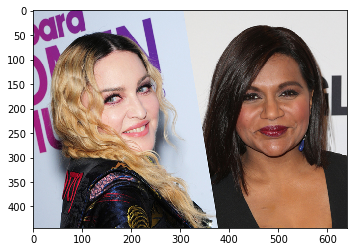

image loaded

2 Face has been detected



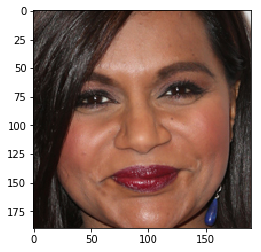

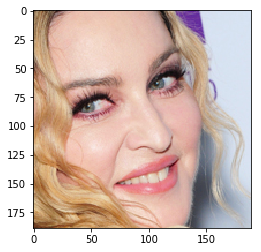


Prediction results:

This face has been recognized as: b'mindy_kaling' with prob 0.417017

Prediction results:

This face has been recognized as: b'madonna' with prob 0.419076


In [143]:
myFaceRecog3.predict_image_faces("images/madonna_mindy.jpg")

loading image...


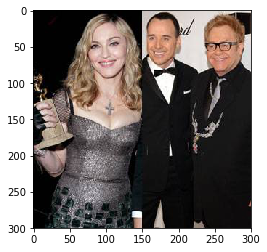

image loaded

3 Face has been detected



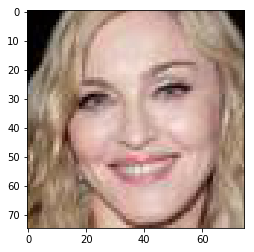

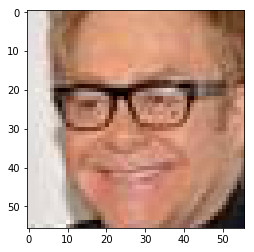

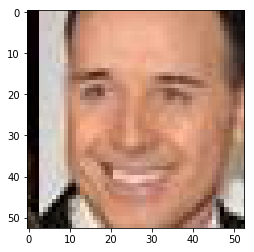


Prediction results:

This face has been recognized as: b'madonna' with prob 0.464981

Prediction results:

This face has been recognized as: b'elton_john' with prob 0.353945

Prediction results:

This face has been recognized as: b'jerry_seinfeld' with prob 0.280432


In [144]:
myFaceRecog3.predict_image_faces("images/madonna_elton.jpg")